In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

process_dataset('inference')


[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|██████████| 473/473 [00:06<00:00, 75.25it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,...,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
469,0.060071,0.144546,0.310245,-0.195478,0.505723,-0.337960,-1.312457,13,2.450196,0.015352,...,17,78,945,S852576,v1.2.4,ok,91,6.921099,5g,model_b
470,0.558987,1.950833,8.567100,-4.938564,13.505664,0.908525,4.674787,8,411.821559,-0.130941,...,30,34,574,S639486,v1.2.3,recent,95,8.046290,4g,model_a
471,0.102132,0.273789,1.820321,-0.219719,2.040041,3.268718,16.336809,1,8.539161,0.016576,...,26,23,55,S935107,v1.2.4,ok,76,7.027533,4g,model_a


In [3]:
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")
#labels as gt 

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)


In [ ]:
#first calculate accuracy, precision, recall, f1
confusion_matrix_df = pd.DataFrame({
    'sample_id': df_inf['sample_id'],
    'ground_truth': labels['label'],
    'predicted': preds,
    'probability': probs.max(axis=1)
})


inference_merged_df = pd.merge(df_inf, confusion_matrix_df, on='sample_id')


def evaluate_predictions_from_df(df, ground_truth_col, predicted_col, source_name="dataset"):
    y_true = df[ground_truth_col]
    y_pred = df[predicted_col]

    labels = sorted(df[ground_truth_col].unique())

    positive_label = 'collision'  
    negative_label = 'normal'     

    TP = ((y_pred == positive_label) & (y_true == positive_label)).sum()
    TN = ((y_pred == negative_label) & (y_true == negative_label)).sum()
    FP = ((y_pred == positive_label) & (y_true == negative_label)).sum()
    FN = ((y_pred == negative_label) & (y_true == positive_label)).sum()

    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total > 0 else float("nan")
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return pd.DataFrame({
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1],
        'True_Positives_c': [TP],
        'True_Negatives_c': [TN],
        'False_Positives_c': [FP],
        'False_Negatives_c': [FN],
        'source': [source_name]
    })

inference_matrix_df = evaluate_predictions_from_df(inference_merged_df, 'ground_truth', 'predicted', source_name='inference_set')
inference_matrix_df

# #swift conf matrix using classification report
# preds_df = pd.DataFrame({
#     'sample_id': df_inf['sample_id'],
#     'predicted': preds
# })

# merged = labels.merge(preds_df, on='sample_id')
# print(classification_report(merged['label'], merged['predicted']))


,accuracy,precision,recall,f1_score,True_Positives_c,True_Negatives_c,False_Positives_c,False_Negatives_c,source
0,0.513742,0.507812,0.826271,0.629032,195,48,189,41,inference_set


In [5]:
#this is checking the test set to get prediction and probability anf then compare to the inference set matrix
df_test = pd.read_csv("data/test.csv")
clean_test = df_test.drop(columns=["label", "sample_id"])
test_gt = df_test["label"]

test_prediction = model.predict(clean_test)
probs_test = model.predict_proba(clean_test)

#swift conf matrix info using classification report
#print(classification_report(y_test, y_pred_test))


confusion_test_df = pd.DataFrame({
    'sample_id': df_test['sample_id'],
    'ground_truth': test_gt,
    'predicted': test_prediction,
    'probability': probs_test.max(axis=1)
})

merged_test_df = pd.merge(df_test, confusion_test_df, on='sample_id')

test_matrix_df = evaluate_predictions_from_df(confusion_test_df, 'ground_truth', 'predicted', source_name='test_set')
test_matrix_df

comparison_df = pd.concat([test_matrix_df, inference_matrix_df], ignore_index=True)
comparison_df



,accuracy,precision,recall,f1_score,True_Positives_c,True_Negatives_c,False_Positives_c,False_Negatives_c,source
0,0.945000,1.000000,0.890000,0.941799,89,100,0,11,test_set
1,0.513742,0.507812,0.826271,0.629032,195,48,189,41,inference_set


Test Set Balance:
 label
normal       0.5
collision    0.5
Name: proportion, dtype: float64
Inference Set Balance:
 ground_truth
normal       0.501057
collision    0.498943
Name: proportion, dtype: float64
Test Set Counts:
 label
normal       100
collision    100
Name: count, dtype: int64
Inference Set Counts:
 label
normal       237
collision    236
Name: count, dtype: int64


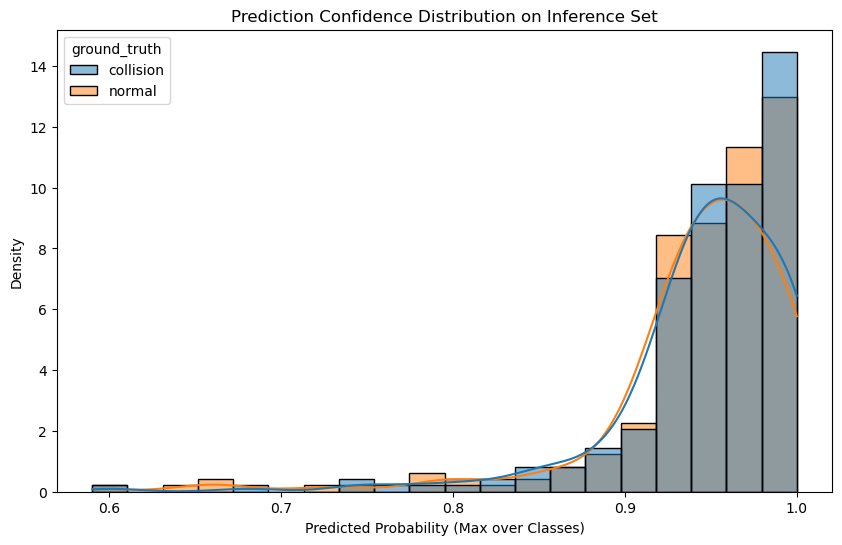

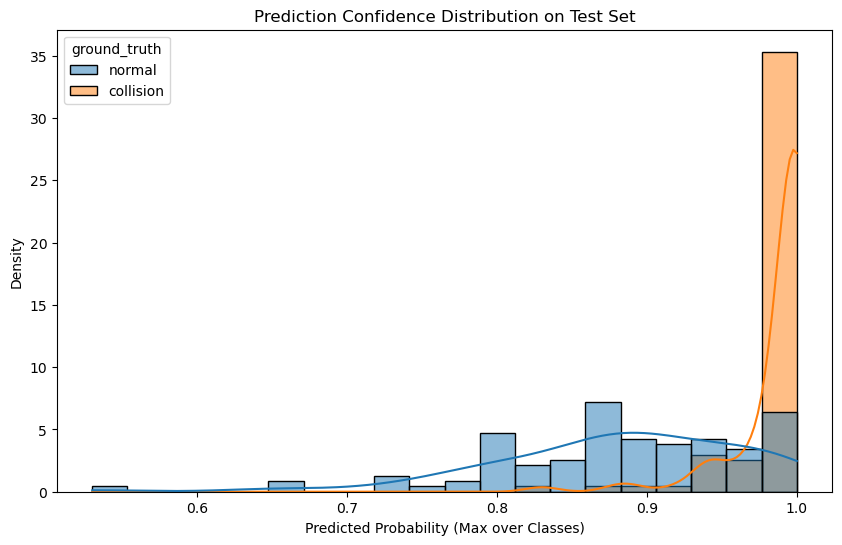

In [6]:
#exploration of the confusion matrix to identify problems 

#gt balance test 
balance_check_test = merged_test_df['label'].value_counts(normalize=True)
balance_check_iference = inference_merged_df['ground_truth'].value_counts(normalize=True)
print("Test Set Balance:\n", balance_check_test)
print("Inference Set Balance:\n", balance_check_iference)

#note: representation of the labels seem to be balanced

#counts check
print("Test Set Counts:\n", df_test['label'].value_counts())
print("Inference Set Counts:\n", labels['label'].value_counts())
#note: larger counts on the inference set, but not a problem

#probability distribution check for inference set
plt.figure(figsize=(10, 6))
sns.histplot(data=inference_merged_df, x='probability', hue='ground_truth', bins=20, kde=True, stat="density", common_norm=False)
plt.title("Prediction Confidence Distribution on Inference Set")
plt.xlabel("Predicted Probability (Max over Classes)")
plt.ylabel("Density")
plt.show()

#note: the distribution of the probabilities seems to be similar for both classes, but the normal class has a small higher density at lower probabilities

#probability distribution check for test set
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_test_df, x='probability', hue='ground_truth', bins=20, kde=True, stat="density", common_norm=False)
plt.title("Prediction Confidence Distribution on Test Set")
plt.xlabel("Predicted Probability (Max over Classes)")
plt.ylabel("Density")
plt.show()

#note: the distribution of the probabilities seems to be similar for both classes, but the normal class has a higher density at lower probabilities. 
#which means the model is more confident about collisions than normal events, which is against expectations since both classes are equally represented in the set.
#speculation: the model might be overfitting to the collision class, or the features extracted from the IMU data are more indicative of collisions than normal events.
#speculation: training data might have more noise or variability in normal events, making it harder for the model to learn a clear pattern. inference set, the model might be more confident about collisions because they are more distinct events compared to normal events.
#why does the model is not as sure on normal events as it is on collisions? follow up


In [7]:
def analyze_prediction_errors(inference_df, test_df):

    # Inference errors
    error_check_inference = inference_df[inference_df['ground_truth'] != inference_df['predicted']]
    print("Inference set prediction errors:")
    print(error_check_inference[['sample_id', 'ground_truth', 'predicted', 'probability']])

    # Test errors
    error_check_test = test_df[test_df['ground_truth'] != test_df['predicted']]
    print("\nTest set prediction errors:")
    print(error_check_test[['sample_id', 'ground_truth', 'predicted', 'probability']])

    # Note: knowing false negative id count 41 and false positive is count 189 from comparison_df
    # The main problem is false positives, which means the model is predicting normal events as collisions
    # more often than the opposite.

    # Speculation: model might have overrepresented the collision class during training,
    # leading to more false positives on normal events in the inference set.

    # Test set is accurate to the point of very few errors, but the inference set has more errors,
    # which is expected since the inference set is larger and the model is not as confident on normal events.

    return error_check_inference, error_check_test

error_check_inference, error_check_test = analyze_prediction_errors(inference_merged_df, merged_test_df)



Inference set prediction errors:
                                sample_id ground_truth  predicted  probability
0    0143cf13-fd51-44fd-8dd4-c2c92f5db7bd    collision     normal         0.94
7    03f4bf62-6f49-4c9f-a717-fef8cfc65cd4    collision     normal         0.88
13   064c0a70-d717-4a38-9f15-c6efeeb2b03f    collision     normal         0.98
14   06e22d96-5314-4c39-9c12-c76dd01abd64    collision     normal         0.85
18   08dce9cc-f842-4201-a248-66448d352887    collision     normal         0.74
..                                    ...          ...        ...          ...
466  fc80d37d-ac0d-4544-a244-0aa385b63d04       normal  collision         0.98
468  fd5548de-22c7-4a7a-9a60-a72a111cfb0d       normal  collision         0.93
470  fe1c72bc-e38f-4be2-b322-25b2561ccd0c       normal  collision         0.93
471  fe6c5e6e-48d1-4b0f-988d-e360c28196fc       normal  collision         1.00
472  ff0fa9b3-0755-4f81-9a92-6ecb4093230c       normal  collision         0.95

[230 rows x 4 colu

In [8]:
#speculation: identification of the normal events in the inference set using singlas are indicating similarity to collision events.
#error_check_inference[['sample_id', 'ground_truth', 'predicted', 'probability', 'x_n_peaks', 'y_n_peaks', 'sudden_change_score', 'max_delta_mag']]
# merged_test_df[['sample_id', 'ground_truth', 'predicted', 'probability', 'x_n_peaks', 'y_n_peaks', 'sudden_change_score']]
# error_check_test[['sample_id', 'ground_truth', 'predicted', 'probability', 'x_n_peaks', 'y_n_peaks', 'sudden_change_score']]

normal_rows = error_check_inference[error_check_inference['ground_truth'] == 'normal'][[
    'sample_id', 'ground_truth', 'predicted', 'probability', 
    'x_n_peaks', 'y_n_peaks', 'sudden_change_score', 'max_delta_mag'
]]

collision_rows = error_check_inference[error_check_inference['ground_truth'] != 'collision'][[
    'sample_id', 'ground_truth', 'predicted', 'probability', 
    'x_n_peaks', 'y_n_peaks', 'sudden_change_score', 'max_delta_mag'
]]

print(normal_rows)
print(collision_rows)

#compare to the test set, not only with errors becasue there is only one type of error in the test set FN

# normal_rows_test = merged_test_df[merged_test_df['ground_truth'] == 'normal'][[
#     'sample_id', 'ground_truth', 'predicted', 'probability', 
#     'x_n_peaks', 'y_n_peaks', 'sudden_change_score', 'max_delta_mag'
# ]]

collision_rows_test = merged_test_df[merged_test_df['ground_truth'] != 'collision'][[
    'sample_id', 'ground_truth', 'predicted', 'probability', 
    'x_n_peaks', 'y_n_peaks', 'sudden_change_score', 'max_delta_mag'
]]

print(collision_rows_test)

#need to check traingin data for comparison
df_training_data = pd.read_csv("data/train.csv").copy()

collision_rows_training_data = df_training_data[df_training_data['label'] == 'collision'][[
    'sample_id', 'label', 'x_n_peaks', 'y_n_peaks', 'sudden_change_score', 'max_delta_mag'
]]
normal_rows_training_data = df_training_data[df_training_data['label'] == 'normal'][[
    'sample_id', 'label','x_n_peaks', 'y_n_peaks', 'sudden_change_score', 'max_delta_mag'
]]



                                sample_id ground_truth  predicted  \
236  7b682089-560f-4bb0-b375-98417a708ceb       normal  collision   
237  7be9993c-d681-4070-b8a9-cf6967521c46       normal  collision   
238  7cdcde2c-bf4a-4110-86a0-22c2db71552f       normal  collision   
239  7d507ff3-4816-4472-a28a-9bd9aa8b7080       normal  collision   
240  7e7fb8a0-ad09-4fcd-962c-3d473ebb5550       normal  collision   
..                                    ...          ...        ...   
466  fc80d37d-ac0d-4544-a244-0aa385b63d04       normal  collision   
468  fd5548de-22c7-4a7a-9a60-a72a111cfb0d       normal  collision   
470  fe1c72bc-e38f-4be2-b322-25b2561ccd0c       normal  collision   
471  fe6c5e6e-48d1-4b0f-988d-e360c28196fc       normal  collision   
472  ff0fa9b3-0755-4f81-9a92-6ecb4093230c       normal  collision   

     probability  x_n_peaks  y_n_peaks  sudden_change_score  max_delta_mag  
236         1.00         19          3                    3       0.727951  
237         0.99 

In [9]:
def calculate_average_features(rows, label):
    avg_x_n_peaks = rows['x_n_peaks'].mean()
    avg_y_n_peaks = rows['y_n_peaks'].mean()
    avg_sudden_change_score = rows['sudden_change_score'].mean()
    max_x_n_peaks = rows['x_n_peaks'].max()
    max_y_n_peaks = rows['y_n_peaks'].max()
    max_sudden_change_score = rows['sudden_change_score'].max()
    min_x_n_peaks = rows['x_n_peaks'].min()
    min_y_n_peaks = rows['y_n_peaks'].min()
    min_sudden_change_score = rows['sudden_change_score'].min()
    print(f"Average x_n_peaks: {avg_x_n_peaks}, Max: {max_x_n_peaks}, Min: {min_x_n_peaks}")
    print(f"Average y_n_peaks: {avg_y_n_peaks}, Max: {max_y_n_peaks}, Min: {min_y_n_peaks}")
    print(f"Average sudden_change_score: {avg_sudden_change_score}, Max: {max_sudden_change_score}, Min: {min_sudden_change_score}")
    print(f"Number of rows: {len(rows)} for gt {label} events")
    return avg_x_n_peaks, avg_y_n_peaks, avg_sudden_change_score, max_x_n_peaks, max_y_n_peaks, max_sudden_change_score, min_x_n_peaks, min_y_n_peaks, min_sudden_change_score

collision_rows_calculated = calculate_average_features(collision_rows, 'collision')
normal_rows_calculated = calculate_average_features(normal_rows, 'normal')

normal_inference_overall = calculate_average_features(inference_merged_df, 'normal')
collision_inference_overall = calculate_average_features(inference_merged_df, 'collision')

normal_test_overall = calculate_average_features(merged_test_df, 'normal')
collision_test_overall = calculate_average_features(merged_test_df, 'collision')

collision_rows_training_data_calc = calculate_average_features(collision_rows_training_data, 'collision')
normal_rows_training_data_calc = calculate_average_features(normal_rows_training_data, 'normal')

wanted_metrics = [
    'x_n_peaks', 'y_n_peaks', 'sudden_change_score',
    'max_x_n_peaks', 'max_y_n_peaks', 'max_sudden_change_score',
    'min_x_n_peaks', 'min_y_n_peaks', 'min_sudden_change_score'
]

calculations_comparison_df = pd.DataFrame({
    'metrics': wanted_metrics,
    'collision_inference_errors': collision_rows_calculated,
    'normal_inference_errors': normal_rows_calculated,
    'normal_inference_overall': normal_inference_overall,
    'collision_inference_overall': collision_inference_overall,
    'normal_test_overlall': normal_test_overall,
    'collision_test_overall': collision_test_overall,
    'collision_training_overall': collision_rows_training_data_calc,
    'normal_training_overall': normal_rows_training_data_calc
})

calculations_comparison_df

Average x_n_peaks: 12.507936507936508, Max: 34, Min: 1
Average y_n_peaks: 15.571428571428571, Max: 35, Min: 2
Average sudden_change_score: 4.947089947089947, Max: 9, Min: 1
Number of rows: 189 for gt collision events
Average x_n_peaks: 12.507936507936508, Max: 34, Min: 1
Average y_n_peaks: 15.571428571428571, Max: 35, Min: 2
Average sudden_change_score: 4.947089947089947, Max: 9, Min: 1
Number of rows: 189 for gt normal events
Average x_n_peaks: 12.953488372093023, Max: 35, Min: 1
Average y_n_peaks: 13.11416490486258, Max: 35, Min: 1
Average sudden_change_score: 4.892177589852008, Max: 9, Min: 1
Number of rows: 473 for gt normal events
Average x_n_peaks: 12.953488372093023, Max: 35, Min: 1
Average y_n_peaks: 13.11416490486258, Max: 35, Min: 1
Average sudden_change_score: 4.892177589852008, Max: 9, Min: 1
Number of rows: 473 for gt collision events
Average x_n_peaks: 12.545, Max: 21, Min: 1
Average y_n_peaks: 4.48, Max: 8, Min: 2
Average sudden_change_score: 4.05, Max: 9, Min: 0
Number 

,metrics,collision_inference_errors,normal_inference_errors,normal_inference_overall,collision_inference_overall,normal_test_overlall,collision_test_overall,collision_training_overall,normal_training_overall
0,x_n_peaks,12.507937,12.507937,12.953488,12.953488,12.545,12.545,11.2725,15.8625
1,y_n_peaks,15.571429,15.571429,13.114165,13.114165,4.480,4.480,4.6525,4.5400
2,sudden_change_score,4.947090,4.947090,4.892178,4.892178,4.050,4.050,3.4950,4.3575
3,max_x_n_peaks,34.000000,34.000000,35.000000,35.000000,21.000,21.000,20.0000,21.0000
4,max_y_n_peaks,35.000000,35.000000,35.000000,35.000000,8.000,8.000,8.0000,7.0000
5,max_sudden_change_score,9.000000,9.000000,9.000000,9.000000,9.000,9.000,8.0000,10.0000
6,min_x_n_peaks,1.000000,1.000000,1.000000,1.000000,1.000,1.000,1.0000,10.0000
7,min_y_n_peaks,2.000000,2.000000,1.000000,1.000000,2.000,2.000,2.0000,1.0000
8,min_sudden_change_score,1.000000,1.000000,1.000000,1.000000,0.000,0.000,1.0000,0.0000


In [10]:
#checked visualization of the errors
error_check_inference_list = error_check_inference['sample_id'].tolist()

inference_merged_df['sample_id'] = inference_merged_df['sample_id'].astype(str).str.zfill(6)
error_check_inference_list = [str(sid).zfill(6) for sid in error_check_inference['sample_id'].tolist()]

filtered_df = inference_merged_df[inference_merged_df['sample_id'].isin(error_check_inference_list)]

filtered_labels_df = pd.DataFrame({
    'sample_id': filtered_df['sample_id'],
    'label': filtered_df['ground_truth']
})

filtered_df = filtered_df.drop(columns=['ground_truth', 'predicted', 'probability'])

# filtered_labels_df.to_csv("sensor-analysis-assignment/inference_labels_filtered.csv", index=False)
# filtered_df.to_csv("sensor-analysis-assignment/inference_df_filtered.csv", index=False)

# signal_viewer(
#     data_dir=Path('data/raw/inference'),
#     labels_csv=Path('C:/ShacharCode/sensor-analysis-assignment/inference_labels_filtered.csv')
#     )


#Thresholds should be adjusted to reduce false positives on normal events.

In [11]:
#inference in comparison to training data possible extra cuses check 
#speculation: after looking into the train data file and structure 
#the model might be more confident on collisions than normal events because the weather conditions in the inference set are different 
#from the training set, leading to more false positives on normal events.

def compare_categorical_distributions(train_df, inference_df, columns_to_check):
    for column in columns_to_check:
        print(f"\n=== {column.upper()} DISTRIBUTION CHECK ===")
        print("Inference Set:")
        print(inference_df[column].value_counts())
        print("\nTraining Set:")
        print(train_df[column].value_counts())
        print("\n" + "-" * 40)

df_train = pd.read_csv("data/train.csv")
columns = ['weather', 'speed_bin', 'time_of_day']
compare_categorical_distributions(df_train, inference_merged_df, columns)

#note: weather condition is not the issue. 
#speed check
#note: speed data is not the issue
#time of day check
#speculation: night time overrepresentation can cause visul noise and can cause confusing results when trained.
#note: time of day representation is not the issue. 



=== WEATHER DISTRIBUTION CHECK ===
Inference Set:
weather
rain     172
fog      158
clear    143
Name: count, dtype: int64

Training Set:
weather
fog      292
clear    257
rain     251
Name: count, dtype: int64

----------------------------------------

=== SPEED_BIN DISTRIBUTION CHECK ===
Inference Set:
speed_bin
slow      166
fast      160
medium    147
Name: count, dtype: int64

Training Set:
speed_bin
fast      274
medium    269
slow      257
Name: count, dtype: int64

----------------------------------------

=== TIME_OF_DAY DISTRIBUTION CHECK ===
Inference Set:
time_of_day
afternoon    126
night        121
evening      116
morning      110
Name: count, dtype: int64

Training Set:
time_of_day
afternoon    219
night        209
evening      186
morning      186
Name: count, dtype: int64

----------------------------------------


# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

discrepancy in Peak Features Between Training and Inference Sets
avg_x_n_peaks and avg_y_n_peaks are much higher in the inference false positives than in training:
avg_y_n_peaks for FP is 15.57, compared to 4.65 in training.
This suggests that the inference normal events are noisier or more active, possibly due to environmental factors, causing them to appear like collision events I assume from my experience that often real life event have more background data noise than clean training data.
Similarly, in FN (missed collisions), avg_x_n_peaks is 15.66, which is higher than in the training collision class (11.27).
This could indicate that the model learned a lower threshold for x_n_peaks during training.

another factor is misalignment in sudden_change_score
both FP and FN in inference have higher sudden_change_score than the training data (4.44–4.95 vs 3.50).
even though this is not a large change this suggests that events the model misclassified are generally more sudden than what it saw in training. possible underrepresentation of high score for sudden_change events in the training set.

I also suspected extreme Max_Values in FP as a reason for not accurate threshold 
max_x_n_peaks and max_y_n_peaks are significantly higher in FP (34–35) than in any other group.
This suggests a need to clamp or threshold outliers during preprocessing or retraining.
also the lower Min_Values in FP min_x_n_peaks is 1 in FP, same as training data, but the range is wider.
wider range in FP might indicate higher variance, possibly due to unseen road or vehicle types.

reccomendations based on what I learned from the data:
model gets confused due to "Signal Noise" High number of peaks and sudden changes in FP samples 
means the model mistakes noisy normal driving for collisions.
recommendation: add more diverse normal events in training that include rough driving but no collision.

model sometimes misses subtle or "small" collisions
in FN, sudden_change_score is slightly higher than in training collisions that means model misses "smaller" collisions that are visually noisy but not extreme.

short term solution: threshold adjustment
that will defintley help to reduce false positives on normal events.

recalibrate decision thresholds on key features:
sudden_change_score to raise threshold slightly to ignore noisy normal events.
x_n_peaks, y_n_peaks to add upper/lower bounds to filter overly active signals.

also it is possible to apply a simple rule based filteration such as:
classify as collision only if sudden_change_score > 4.5 and x_n_peaks > 15.
this is not the best solution but it can reduce misclassification without retraining. but may sacrifice generalization if overfit to current inference set.

long Term Solution: data in training balance
add more normal samples that are "noisy" or contain strong movement patterns but no collision.
use hard negatives normal events with high sudden_change_score or many peaks cases.

another long term solution can be calibration of confidence of the model
to use confidence calibration techniques to better interpret model probabilities and descision making.

overall throughut the test I noticed that both test df and inference results were inconsistent in metrics and signals to training data. but in the test set the threshold is set up for high accuracy but less coverage. however even if most issues generated in inference set. test set also should also benefit from the threshold adjusted to count more cases as collisin when it classifies as normal. and the inference data set was not showing same decesion making as its data is not correlated with decisions made in training data. 
I also noticed a probability anomaly for test set it is because it considers most signal reads to be collision since its 

- I also added my own notes mid analysis just to give more insight about my way of solving issues. 
